In [1]:
from neurodiffeq import diff      # the differentiation operation
from neurodiffeq.ode import solve # the ANN-based solver
from neurodiffeq.conditions import IVP   # the initial condition
from neurodiffeq.networks import FCNN    # fully-connect neural network
#from neurodiffeq.networks import SinActv # sin activation
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.ode import solve_system
from neurodiffeq.solvers import Solver1D
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import torch.nn as nn

<IPython.core.display.Javascript object>


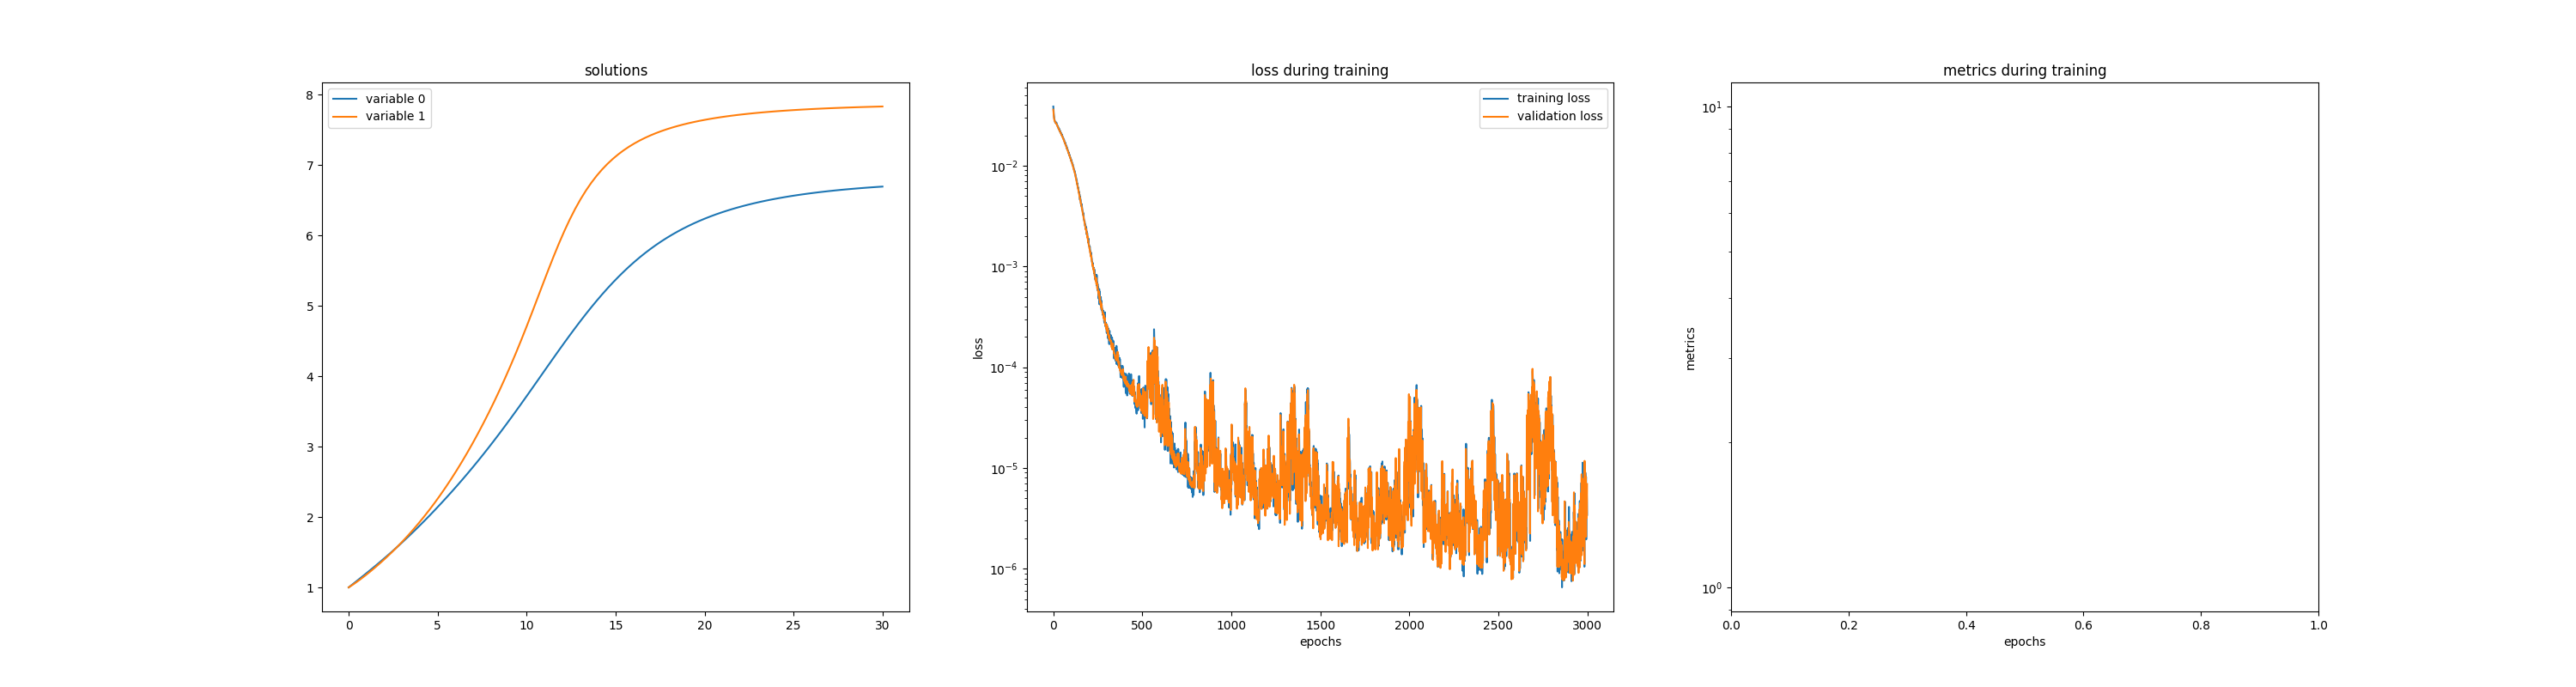

/nfshome/sa6h/myenv/lib/python3.6/site-packages/neurodiffeq/ode.py:262: FutureWarning: The `solve_system` function is deprecated, use a `neurodiffeq.solvers.Solver1D` instance instead
  FutureWarning,
/nfshome/sa6h/myenv/lib/python3.6/site-packages/neurodiffeq/solvers.py:438: UserWarning: Passing `monitor` is deprecated, use a MonitorCallback and pass a list of callbacks instead
  warnings.warn("Passing `monitor` is deprecated, "
Training Progress: 100%|██████████| 3000/3000 [00:57<00:00, 52.08it/s] 


<IPython.core.display.Javascript object>


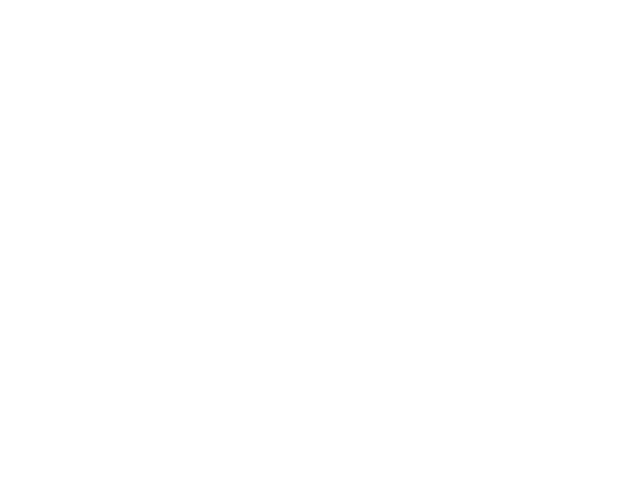

/nfshome/sa6h/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
/nfshome/sa6h/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.


In [2]:
# specify the ODE system and its parameters

a =.18 
b = .002 
s = .13 
p = .1245 
g = .2019 
m = .003422
n = .01101 
d= 0.0412


ETModel = lambda u, v, t : [ diff(v, t) - (a*v*(1-b*v) -n*u*v),
                                    diff(u, t) - (s + (p * u * v/(g+v))-m*u*v-d*u), ]
# specify the initial conditions
init_vals_lv = [
    IVP(t_0=0.0, u_0=1.0),  # 1.5 is the value of u at t_0 = 0.0
    IVP(t_0=0.0, u_0=1.0),  # 1.0 is the value of v at t_0 = 0.0
]

# specify the network to be used to approximate each dependent variable
# the input units and output units default to 1 for FCNN
nets_lv = [
    FCNN(n_input_units=1, n_output_units=1, hidden_units=(32, 32,32), actv=nn.Tanh),
    FCNN(n_input_units=1, n_output_units=1, hidden_units=(32, 32,32), actv=nn.Tanh)
]

# solve the ODE system
solution_lv, _ = solve_system(
    ode_system=ETModel, conditions=init_vals_lv, t_min=0.0, t_max=10,
    nets=nets_lv, max_epochs=3000,
    monitor=Monitor1D(t_min=0.0, t_max=30, check_every=100)
)
fig=plt.figure()
ax1=fig.add_axes()
#plt.plot([1,2])
#fig.savefig('test.png',bbox_inches='tight')
ax2=fig.add_axes()
#plt.plot([1,2])
#fig.savefig('test1.png',bbox_inches='tight')

<IPython.core.display.Javascript object>


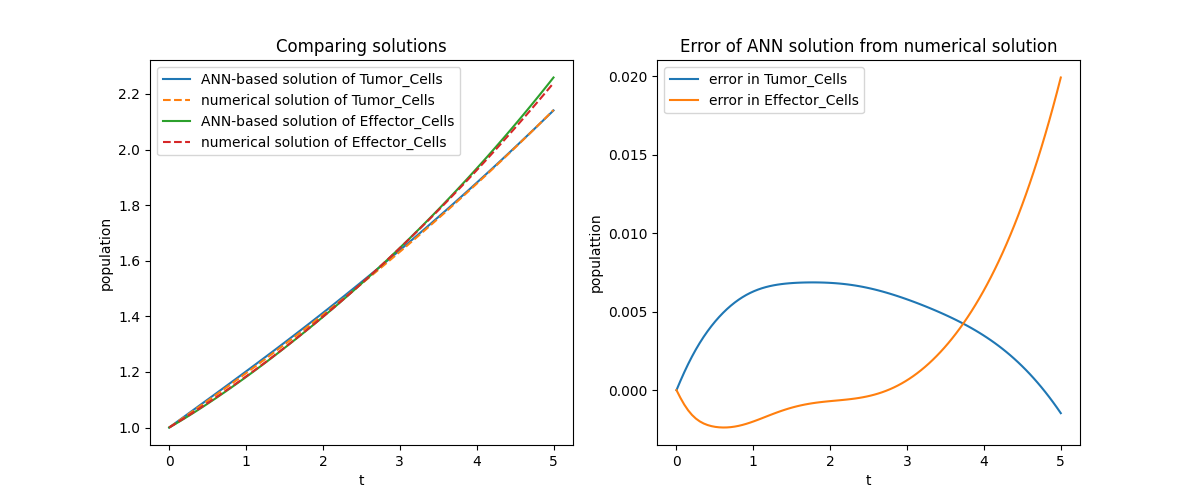

In [6]:
ts = np.linspace(0, 5, 100)

# ANN-based solution
Tumor_net, Effector_net = solution_lv(ts, to_numpy=True)

# numerical solution
from scipy.integrate import odeint

def dPdt(P, t):
    return [a*P[1]*(1-b*P[1])-n*P[0]*P[1], s+(p*P[0]*P[1]/(g+P[1])) - m*P[0]*P[1]-d*P[0] ]
P0 = [1.0, 1.0]
Ps = odeint(dPdt, P0, ts)
Effector_num = Ps[:,0]
Tumor_num = Ps[:,1]

fig = plt.figure(figsize=(12, 5))
ax1, ax2 = fig.subplots(1, 2)
ax1.plot(ts, Tumor_net, label='ANN-based solution of Tumor_Cells')
ax1.plot(ts, Tumor_num, '--', label='numerical solution of Tumor_Cells')
ax1.plot(ts, Effector_net, label='ANN-based solution of Effector_Cells')
ax1.plot(ts, Effector_num, '--', label='numerical solution of Effector_Cells ')


ax1.set_ylabel('population')
ax1.set_xlabel('t')
ax1.set_title('Comparing solutions')
ax1.legend()

ax2.set_title('Error of ANN solution from numerical solution')
ax2.plot(ts, Tumor_net-Tumor_num, label='error in Tumor_Cells')
ax2.plot(ts, Effector_net-Effector_num, label='error in Effector_Cells')

ax2.set_ylabel('populattion')
ax2.set_xlabel('t')
ax2.legend()

<IPython.core.display.Javascript object>


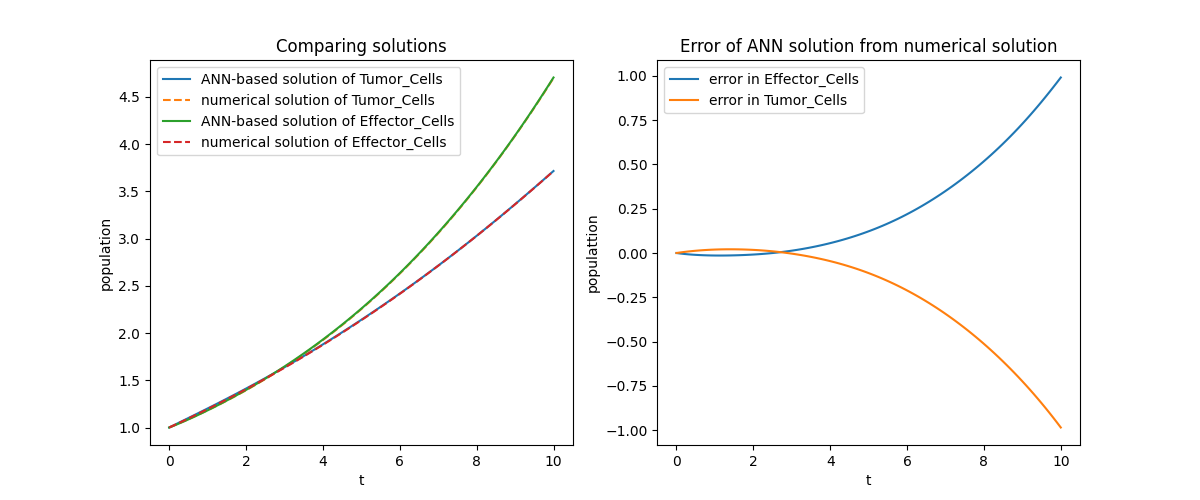

/nfshome/sa6h/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
/nfshome/sa6h/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.


In [7]:
ts = np.linspace(0, 10, 100)

# ANN-based solution
Tumor_net, Effector_net = solution_lv(ts, to_numpy=True)

# numerical solution
from scipy.integrate import odeint

def dPdt(P, t):
    return [s+(p*P[0]*P[1]/(g+P[1])) - m*P[0]*P[1]-d*P[0], a*P[1]*(1-b*P[1])-n*P[0]*P[1]]
P0 = [1.0, 1.0]
Ps = odeint(dPdt, P0, ts)
Effector_num = Ps[:,0]
Tumor_num = Ps[:,1]

fig = plt.figure(figsize=(12, 5))
ax1, ax2 = fig.subplots(1, 2)
ax1.plot(ts, Tumor_net, label='ANN-based solution of Tumor_Cells')
ax1.plot(ts, Tumor_num, '--', label='numerical solution of Tumor_Cells')
ax1.plot(ts, Effector_net, label='ANN-based solution of Effector_Cells')
ax1.plot(ts, Effector_num, '--', label='numerical solution of Effector_Cells ')


ax1.set_ylabel('population')
ax1.set_xlabel('t')
ax1.set_title('Comparing solutions')
ax1.legend()
ax1=fig.add_axes()
#plt.plot([1,2])
#fig.savefig('test3.png',bbox_inches='tight')
ax2.set_title('Error of ANN solution from numerical solution')
ax2.plot(ts, Effector_net-Effector_num, label='error in Effector_Cells')
ax2.plot(ts, Tumor_net-Tumor_num, label='error in Tumor_Cells')

ax2.set_ylabel('populattion')
ax2.set_xlabel('t')
ax2.legend()
ax2=fig.add_axes()
#plt.plot([1,2])
#fig.savefig('test4.png',bbox_inches='tight')
